In [ ]:
!pip install -q keras-nightly # fix orc import
!pip install tensorflow -U -q # fix import PyDataset
!pip install keras-tuner -q

In [ ]:
import google.colab.drive as drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path


zipPath:Path = Path("./drive/MyDrive/Dataset/Captcha/dataset100k.zip")
DatasetFolder:Path = Path("./dataset")
modelFolder:Path = Path('./drive/MyDrive/Dataset/Captcha/Models')
modelName:str = "v14.keras"

In [ ]:
IMAGE_HEIGH:int = 50
IMAGE_WIDTH:int = 150

In [ ]:
import string
OUTPUT_CHARACTERS:str = string.ascii_lowercase + string.ascii_uppercase + "0123456789"

In [ ]:
BATCH_SIZE:int = 16
RANDOM_SEED:int = 4444
SAMPLES_LIMIT:int = -1

In [ ]:
from zipfile import ZipFile


if(not DatasetFolder.exists()):
    print(f"Extracting dataset from {zipPath} to {DatasetFolder}")
    with ZipFile(zipPath, "r") as zip:
        zip.extractall(DatasetFolder)

In [ ]:
import os
from typing import List


images:List[str] = list(map(str, list(DatasetFolder.glob("*.png"))))
labels:List[str] = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
print(f" Total images: {len(images)}")

 Total images: 100000


In [ ]:
from typing import List
from keras.layers import StringLookup


charVocab:List[str] = StringLookup(vocabulary=sorted(OUTPUT_CHARACTERS)).get_vocabulary()
print(f"Chars count: {len(charVocab)}")

Chars count: 63


In [ ]:
maxLenght:int = max([len(label) for label in labels])
print(f"Max captcha length: {maxLenght}")

Max captcha length: 6


In [ ]:
import keras.utils as utils
import tensorflow.random as tf_random
import numpy.random as np_random
tf_random.set_seed(RANDOM_SEED)
utils.set_random_seed(RANDOM_SEED)
np_random.seed(RANDOM_SEED)

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow.io as tf_io
import tensorflow.image as tf_image
import tensorflow.strings as tf_strings
import keras
import keras.ops as ops
from keras.layers import StringLookup
from typing import Dict, List


class DataEncoder():
    @staticmethod
    def PreprocessSample(imagePath:str, label:str) -> Dict[str, np.ndarray]:
        return {
                "image": DataEncoder.EncodeImageV2(imagePath),
                "label": DataEncoder.EncodeLabelV2(label)
                }

    @staticmethod
    def EncodeImage(imagePath:str) -> np.ndarray:
        image:np.ndarray = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE).astype(np.float32)
        image = image / 255.0
        image = np.reshape(image, (IMAGE_HEIGH, IMAGE_WIDTH, 1))
        return image

    @staticmethod
    def EncodeImageV2(imagePath:str) -> np.ndarray:
        image:np.ndarray = tf_io.read_file(imagePath)
        image = tf_io.decode_png(image, channels=1)
        image = tf_image.convert_image_dtype(image, dtype=tf.float32)
        image = ops.image.resize(image, [IMAGE_HEIGH, IMAGE_WIDTH])
        return image

    @staticmethod
    def EncodeLabel(label:str) -> np.ndarray:
        target:np.ndarray = np.zeros((maxLenght, len(charVocab)), dtype=np.int32)
        for charIndex, char in enumerate(label):
            index:int = charVocab.index(char)
            target[charIndex, index] = 1
        return target

    @staticmethod
    def EncodeLabelV2(label:str) -> np.ndarray:
        encoder:StringLookup = StringLookup(vocabulary=charVocab, output_mode="one_hot")
        chars:List[str] = tf_strings.unicode_split(label, input_encoding="UTF-8")
        return encoder(chars)

In [ ]:
import time


def timeBenchmark(testName:str, func):
    start:float = time.time()
    output:np.ndarray = func()
    end:float = time.time()
    print(f"{testName}: {end - start}, type: {type(output)} of {output.dtype}")

In [ ]:
testSample:str = images[0]
timeBenchmark("image V1", lambda: DataEncoder.EncodeImage(testSample))
timeBenchmark("image V2", lambda: DataEncoder.EncodeImageV2(testSample))

image V1: 0.0005147457122802734, type: <class 'numpy.ndarray'> of float32
image V2: 0.010195732116699219, type: <class 'tensorflow.python.framework.ops.EagerTensor'> of <dtype: 'float32'>


In [ ]:
testSample:str = labels[0]
timeBenchmark("label V1", lambda: DataEncoder.EncodeLabel(testSample))
timeBenchmark("label V2", lambda: DataEncoder.EncodeLabelV2(testSample))

label V1: 5.221366882324219e-05, type: <class 'numpy.ndarray'> of int32
label V2: 0.03516077995300293, type: <class 'tensorflow.python.framework.ops.EagerTensor'> of <dtype: 'int64'>


In [ ]:
import numpy as np


class DataDecoder():
    @staticmethod
    def DecodeLabel(encodedLabel:np.ndarray, debug:bool=False) -> str:
        label:str = ""
        for char in encodedLabel:
            bestProf:float = max(char)
            index:int = char.tolist().index(bestProf)
            if(debug):
                print(charVocab[index], bestProf, end=", ")
            label += charVocab[index]
        return label

In [ ]:
import numpy as np
from keras.utils import PyDataset
from typing import Dict, List


class CaptchaDataset(PyDataset):
    def __init__(self, images:list, labels:list, batchSize:int, samplesLimit:int = -1, **kwargs) -> None:
        super().__init__(**kwargs)
        if(samplesLimit == -1):
            samplesLimit = min(len(images), len(labels))
        self.images:List[str] = images[:samplesLimit]
        self.labels:List[str] = labels[:samplesLimit]
        self.batchSize:int = batchSize

    def __len__(self) -> int:
        return int(np.floor(len(self.images) / float(self.batchSize)))

    def __getitem__(self, index:int) -> tuple:
        start:int = index * self.batchSize
        end:int = min(start + self.batchSize, len(self.images))
        return (np.array([DataEncoder.EncodeImage(image) for image in self.images[start:end]]),
                np.array([DataEncoder.EncodeLabelV2(label) for label in self.labels[start:end]]))

In [ ]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(images, labels, train_size=0.9, random_state=RANDOM_SEED, shuffle=True)
trainDataset = CaptchaDataset(x_train, y_train, BATCH_SIZE, SAMPLES_LIMIT, use_multiprocessing=True, workers=2)
testDataset = CaptchaDataset(x_test, y_test, BATCH_SIZE, SAMPLES_LIMIT, use_multiprocessing=True, workers=2)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class CaptchaVisualizer():
    @staticmethod
    def ShowBatch(images:np.ndarray, labels:np.ndarray, decodeLogging:bool=False):
        _, ax = plt.subplots(4, 4, figsize=(16, 8))
        for i in range(16):
            ax[i // 4, i % 4].imshow(images[i], cmap="gray")
            ax[i // 4, i % 4].set_title(DataDecoder.DecodeLabel(labels[i], decodeLogging))
            ax[i // 4, i % 4].axis("off")
            if(decodeLogging):
                print()
        plt.show()

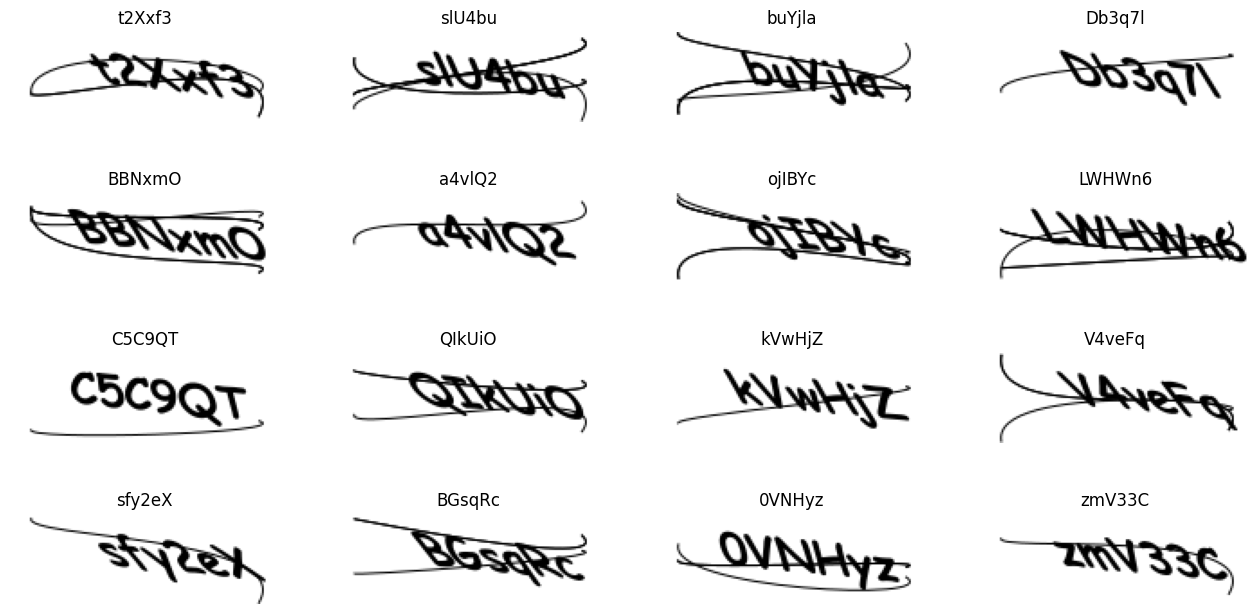

In [ ]:
CaptchaVisualizer.ShowBatch(trainDataset[0][0], trainDataset[0][1])

In [ ]:
import keras.layers as layers
import keras.losses as losses
import keras.optimizers as optimizers
from keras.models import Model



def createmodel() -> Model:
    input:layers.Layer = layers.Input((IMAGE_HEIGH, IMAGE_WIDTH,  1))
    x:layers.Layer = layers.Conv2D(16, 3, activation="relu", padding="same")(input)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    chars = [layers.Dense(len(charVocab), activation="softmax")(x) for _ in range(maxLenght)]
    x = layers.Concatenate()(chars)
    output = layers.Reshape((maxLenght, len(charVocab)))(x)
    model:Model = Model(input, outputs=output)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer="adam", metrics=["accuracy"])
    return model

In [ ]:
import keras.layers as layers
import keras.losses as losses
import keras.optimizers as optimizers
import keras_tuner as tuner
from keras.models import Model
from pathlib import Path


def tuningModel(hp:tuner.HyperParameters) -> Model:
    convFilter1:int|None = hp.Int("convFilter1", min_value=16, max_value=32, step=16)
    convPadding:str|None = hp.Choice("convPadding", ["valid", "same"])
    enableNormalizetion:int|None = hp.Choice("enableNormalizetion", [-1, 0, 1])  # -1 - not, 0 - only first, 1 - after every conv
    convFilter2:int|None = hp.Int("convFilter2", min_value=32, max_value=64, step=16)
    additionalConvLayers:int|None = hp.Int("additionalConvLayers", 0, 3, default=0)
    dense1Units:int|None = hp.Int("dense1Units", min_value=32, max_value=256, step=32)
    dense2Activation:str|None = hp.Choice("dense2Activation", ["relu", "leaky_relu", "tanh"])
    dropout:float|None = hp.Float("dropout", min_value=0.1, max_value=0.5, step=0.1)
    optimizer:str|None = hp.Choice("optimizer", ["adam", "SGD", "RMSprop", "Lion"])
    learningRate:float|None = hp.Float("LR", min_value=1e-4, max_value=1e-2, sampling="log")

    def AddConvLayer(x:layers.Layer, filters:int|None, padding:str|None, enableNormalization:bool|None) -> layers.Layer:
        x = layers.Conv2D(convFilter2, 3, activation="relu", padding=padding)(x)
        if(enableNormalization):
             x = layers.BatchNormalization()(x)
        return layers.MaxPooling2D()(x)

    input:layers.Layer = layers.Input((IMAGE_HEIGH, IMAGE_WIDTH,  1), name="image")
    x:layers.Layer = AddConvLayer(input, convFilter1, convPadding, enableNormalizetion>=0)
    x = AddConvLayer(x, convFilter2, convPadding, enableNormalizetion==1)
    if(additionalConvLayers >= 1): x = AddConvLayer(x, convFilter2, convPadding, enableNormalizetion==1)
    if(additionalConvLayers >= 2): x = AddConvLayer(x, convFilter2, convPadding, enableNormalizetion==1)
    if(additionalConvLayers >= 3): x = AddConvLayer(x, convFilter2, convPadding, enableNormalizetion==1)
    x = layers.Flatten()(x)
    x = layers.Dense(dense1Units, dense2Activation)(x)
    x = layers.Dropout(dropout)(x)
    chars = [layers.Dense(len(charVocab), activation="softmax")(x) for _ in range(maxLenght)]
    x = layers.Concatenate()(chars)
    x = layers.Reshape((maxLenght, len(charVocab)))(x)

    model:Model = Model(input, outputs=x)
    if(optimizer == "adam"): model.optimizer = optimizers.Adam(learningRate)
    elif(optimizer == "SGD"): model.optimizer = optimizers.SGD(learningRate)
    elif(optimizer == "RMSprop"): model.optimizer = optimizers.RMSprop(learningRate)
    elif(optimizer == "Lion"): model.optimizer = optimizers.Lion(learningRate)
    model.compile(
        loss=losses.CategoricalCrossentropy(),
        metrics=["accuracy"])
    return model

# bayes 40 trials
# hyperparamsSearch(Hyperband) 200 trials
modelTuner:tuner.Tuner = tuner.BayesianOptimization(
    hypermodel=tuningModel,
    objective="val_accuracy",
    executions_per_trial=2,
    seed=RANDOM_SEED,
    directory=Path(modelFolder, "hyperparams"),
    project_name="bayes",
    #overwrite=True,
    max_trials=100,
    #hyperband_iterations=200
)
modelTuner.search_space_summary()

Reloading Tuner from drive/MyDrive/Dataset/Captcha/Models/hyperparams/bayes/tuner0.json
Search space summary
Default search space size: 10
convFilter1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 32, 'step': 16, 'sampling': 'linear'}
convPadding (Choice)
{'default': 'valid', 'conditions': [], 'values': ['valid', 'same'], 'ordered': False}
enableNormalizetion (Choice)
{'default': -1, 'conditions': [], 'values': [-1, 0, 1], 'ordered': True}
convFilter2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
additionalConvLayers (Int)
{'default': 0, 'conditions': [], 'min_value': 0, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
dense1Units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dense2Activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'leaky_relu', 'tanh'], 'ordered': False}
dropout (Float)
{'default': 0.1, 'co

In [ ]:
from keras.models import Model

modelTuner.search(trainDataset, epochs=4, validation_data=testDataset)
modelTuner.results_summary(2)

Results summary
Results in drive/MyDrive/Dataset/Captcha/Models/hyperparams/bayes
Showing 2 best trials
Objective(name="val_accuracy", direction="max")

Trial 052 summary
Hyperparameters:
convFilter1: 16
convPadding: same
enableNormalizetion: -1
convFilter2: 32
additionalConvLayers: 0
dense1Units: 256
dense2Activation: tanh
dropout: 0.1
optimizer: Lion
LR: 0.0001
Score: 0.2460000142455101

Trial 091 summary
Hyperparameters:
convFilter1: 16
convPadding: same
enableNormalizetion: -1
convFilter2: 32
additionalConvLayers: 0
dense1Units: 256
dense2Activation: tanh
dropout: 0.1
optimizer: Lion
LR: 0.0001
Score: 0.24345830082893372


In [ ]:
import keras.layers as layers
import keras.losses as losses
import keras.optimizers as optimizers
import keras.activations as activations
from keras.models import Model


def createmodelV2() -> Model:
    input:layers.Layer = layers.Input((IMAGE_HEIGH, IMAGE_WIDTH,  1))
    x:layers.Layer = layers.Conv2D(16, 3, activation=activations.relu, padding="same")(input)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 3, activation=activations.relu, padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation=activations.tanh)(x)
    x = layers.Dropout(0.1)(x)
    chars = [layers.Dense(len(charVocab), activation=activations.softmax)(x) for _ in range(maxLenght)]
    x = layers.Concatenate()(chars)
    output = layers.Reshape((maxLenght, len(charVocab)))(x)
    model:Model = Model(input, outputs=output)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Lion(1e-4), metrics=["accuracy"])
    return model


In [ ]:
model = createmodelV2()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 50, 150, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 50, 150, 16)    │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 25, 75, 16)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 25, 75, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 12, 37, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 14208)          │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      3,637,504 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 63)             │         16,191 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 63)             │         16,191 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 63)             │         16,191 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 63)             │         16,191 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 63)             │         16,191 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 63)             │         16,191 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 378)            │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_2[0][0],         │
│                           │                        │                │ dense_3[0][0],         │
│                           │                        │                │ dense_4[0][0],         │
│                           │                        │                │ dense_5[0][0],         │
│                           │                        │                │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 6, 63)          │              0 │ concatenate[0][0]      │
└──────────────────────

 Total params: 3,739,450 (14.26 MB)

 Trainable params: 3,739,450 (14.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# https://discuss.python.org/t/concerns-regarding-deprecation-of-fork-with-alive-threads/33555
import keras.callbacks as callbacks
from pathlib import Path


EPOCH_NUM = 100
PATIENCE = 4

early_stopping:callbacks.Callback = callbacks.EarlyStopping(patience=4, restore_best_weights=True, verbose=1)
modelBackup:callbacks.Callback = callbacks.BackupAndRestore(Path(modelFolder, "temp"))
reduceLR:callbacks.Callback = callbacks.ReduceLROnPlateau()

history = model.fit(
    trainDataset,
    validation_data=testDataset,
    epochs=EPOCH_NUM,
    callbacks=[early_stopping, modelBackup, reduceLR],
)
model.save(Path(modelFolder, modelName))

Epoch 1/100


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


5625/5625 ━━━━━━━━━━━━━━━━━━━━ 1834s 325ms/step - accuracy: 0.3934 - loss: 2.5204 - val_accuracy: 0.8937 - val_loss: 0.4570 - learning_rate: 1.0000e-04
Epoch 2/100
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 1819s 323ms/step - accuracy: 0.9099 - loss: 0.3729 - val_accuracy: 0.9296 - val_loss: 0.2874 - learning_rate: 1.0000e-04
Epoch 3/100
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 1846s 327ms/step - accuracy: 0.9505 - loss: 0.1980 - val_accuracy: 0.9395 - val_loss: 0.2431 - learning_rate: 1.0000e-04
Epoch 4/100
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 1896s 330ms/step - accuracy: 0.9661 - loss: 0.1304 - val_accuracy: 0.9429 - val_loss: 0.2260 - learning_rate: 1.0000e-04
Epoch 5/100
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 1873s 328ms/step - accuracy: 0.9742 - loss: 0.0954 - val_accuracy: 0.9424 - val_loss: 0.2297 - learning_rate: 1.0000e-04
Epoch 6/100
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 1832s 325ms/step - accuracy: 0.9786 - loss: 0.0774 - val_accuracy: 0.9442 - val_loss: 0.2276 - learning_rate: 1.0000e-04
Epoch 7/100
5625/5625 ━━━━━━

In [ ]:
model.evaluate(testDataset)

625/625 ━━━━━━━━━━━━━━━━━━━━ 118s 189ms/step - accuracy: 0.9418 - loss: 0.2249


[0.22598671913146973, 0.9429338574409485]

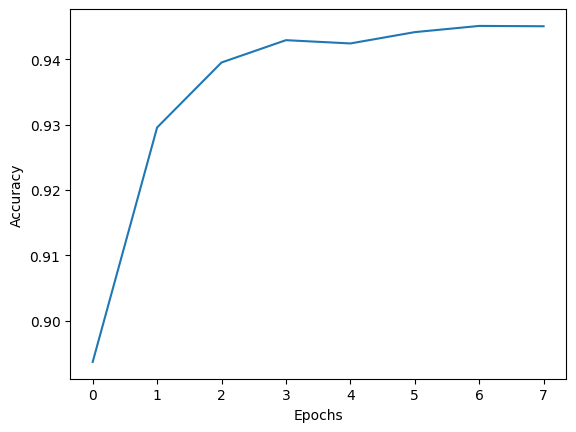

In [ ]:
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
import keras
from pathlib import Path
from keras.models import Model


model:Model = keras.saving.load_model(Path(modelFolder, modelName))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 50, 150, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 50, 150, 16)    │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 25, 75, 16)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 25, 75, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 12, 37, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 14208)          │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      3,637,504 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 63)             │         16,191 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 63)             │         16,191 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 63)             │         16,191 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 63)             │         16,191 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 63)             │         16,191 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 63)             │         16,191 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 378)            │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_2[0][0],         │
│                           │                        │                │ dense_3[0][0],         │
│                           │                        │                │ dense_4[0][0],         │
│                           │                        │                │ dense_5[0][0],         │
│                           │                        │                │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 6, 63)          │              0 │ concatenate[0][0]      │
└──────────────────────

 Total params: 7,478,902 (28.53 MB)

 Trainable params: 3,739,450 (14.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,739,452 (14.26 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


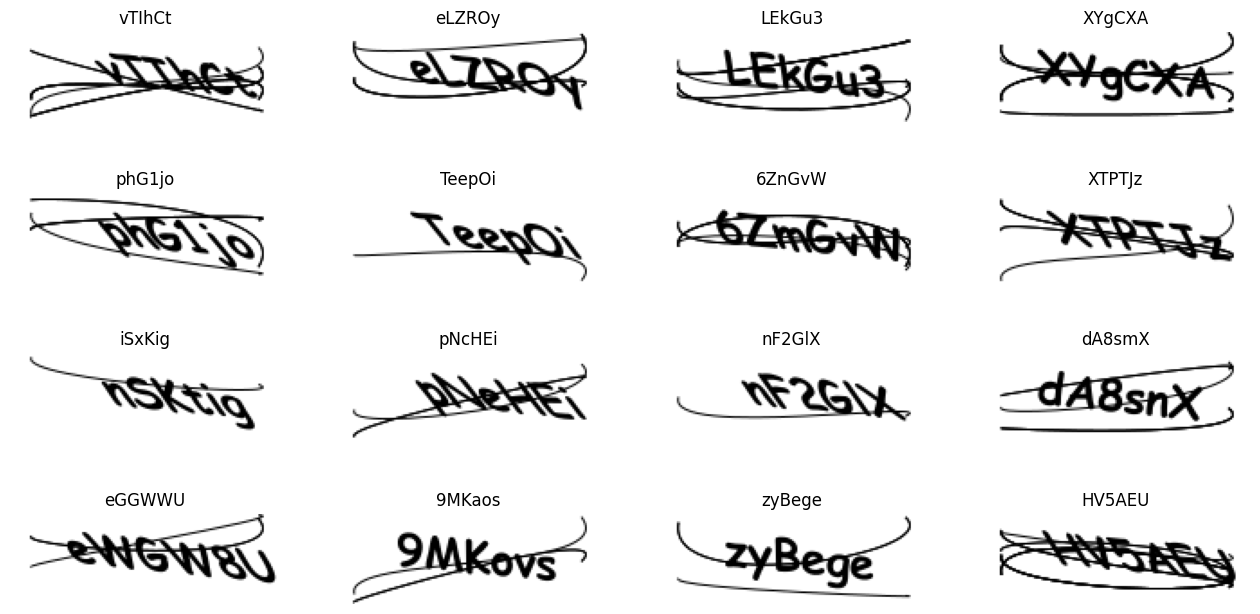

In [ ]:
testImages = testDataset[0][0]
predictedValues = model.predict(testImages)
CaptchaVisualizer.ShowBatch(testImages, predictedValues)

In [ ]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True,
    rankdir="TB",
    show_trainable=True,
    dpi=400
)